# Credit Risk Costumers

## Context

The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. 
Each person is classified as good or bad credit risks according to the set of attributes. The original dataset can be found in the data/raw folder.

## Content

The selected attributes are:
<ol>
<li>Age (numeric)</li>
<li>Sex (text: male, female)</li>
<li>Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)</li>
<li>Housing (text: own, rent, or free)</li>
<li>Saving accounts (text - little, moderate, quite rich, rich)</li>
<li>Checking account (numeric, in DM - Deutsch Mark)</li>
<li>Credit amount (numeric, in DM)</li>
<li>Duration (numeric, in month)</li>
<li>Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)</li>
<li>Risk (Value target - Good or Bad Risk)</li>
</ol>

### Libraries & notebook settings

In [1]:
# Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import squarify
import os
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Warnings
import warnings # A décommenter à la fin
warnings.filterwarnings('ignore') # A décommenter à la fin

# Notebook settings for figures creation
clear_figure_folder = True
generate_figures = True
output_dir_figures = Path("../reports/figures")

if clear_figure_folder:
    for file in output_dir_figures.glob('*.png'):
        file.unlink()

### Import Dataset and Preview the Data

Import dataset

In [2]:
data = pd.read_csv('../data/raw/german_credit_data.csv',index_col = 0)
df = data.copy() # Avoid compromising the original dataframe

Preview the first 10 rows

In [3]:
df.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
5,35,male,1,free,NaN,NaN,9055,36,education,good
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,35,male,3,rent,little,moderate,6948,36,car,good
8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
9,28,male,3,own,little,moderate,5234,30,car,bad


By looking at the head of the dataframe, we can have quick overview of the first data.
Here, we already can see that we will have to deal with NaN values.
Moreover, we see that as some values are text, we will have to convert them into categorical values.

Indeed, the categories Sex, Housing, Saving account, Credit account and Purpose are text.

In [4]:
df.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

Let's have a look at the numerical values. Here we can see that we have 1000 entries. The mean age is 35 and the mean duration for a loan is almost 21 months.

In [5]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


There are 183 null values in the "Saving accounts" and 394 in the "Checking account" categories.

In [7]:
nb_nan_saving_accounts = df['Saving accounts'].isna().sum()
nb_nan_checking_accounts = df['Checking account'].isna().sum()

print("Number of NaN for Saving accounts :", nb_nan_saving_accounts)
print("Number of NaN for Checking accounts :", nb_nan_checking_accounts)

print("\n % of NaN per columns")
(df.isna().sum()/len(df)) * 100

Number of NaN for Saving accounts : 183
Number of NaN for Checking accounts : 394

 % of NaN per columns


Age                  0.0
Sex                  0.0
Job                  0.0
Housing              0.0
Saving accounts     18.3
Checking account    39.4
Credit amount        0.0
Duration             0.0
Purpose              0.0
Risk                 0.0
dtype: float64

It represents respectively 18.3% and 39.4%, which is not negligeable.
We will see later how to deal with these values.

### Data pre-processing (missing values)

This part will handle the data pre-processing, mainly around the NaN values.

As the NaN value are representing almost 48% of my dataset, and that the NaN values are really unbalanced on the risk category (85% of NaN rows are pointing to good risk), I prefer to keep them and create a new category that I will name 'none'.

In [8]:
columns = ['Sex','Job','Housing','Purpose','Risk']
for col in columns:
    print(df[col].value_counts())

Sex
male      690
female    310
Name: count, dtype: int64
Job
2    630
1    200
3    148
0     22
Name: count, dtype: int64
Housing
own     713
rent    179
free    108
Name: count, dtype: int64
Purpose
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: count, dtype: int64
Risk
good    700
bad     300
Name: count, dtype: int64


In [9]:
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')
df.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,unknown,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,unknown,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
5,35,male,1,free,unknown,unknown,9055,36,education,good
6,53,male,2,own,quite rich,unknown,2835,24,furniture/equipment,good
7,35,male,3,rent,little,moderate,6948,36,car,good
8,61,male,1,own,rich,unknown,3059,12,radio/TV,good
9,28,male,3,own,little,moderate,5234,30,car,bad


By replacing NaN values to "unknown", we will consider it as a proper class. We have here an overview of unknown values in Saving and Checking accounts.

### EDA (Exploratory of Data Analysis)

For now, let's go deeper inside the data analysis and the different repartitions.

#### Univariate analysis

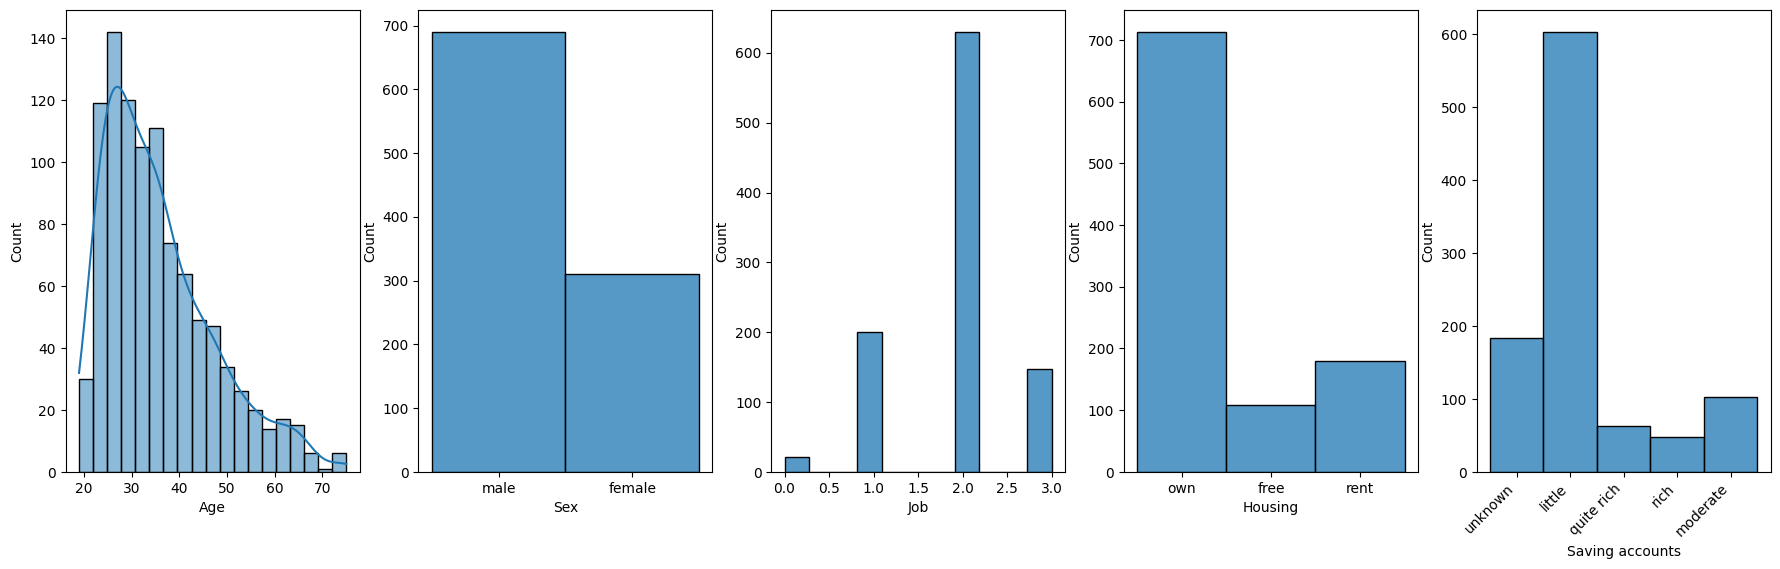

In [10]:
plot_dims = (22, 6)
fig, axs = plt.subplots(ncols=5, figsize=plot_dims)

# Plot 1 : Age
sns.histplot(data=df, x="Age", ax=axs[0], kde=True)
# Plot 2 : Sex
sns.histplot(data=df, x="Sex", ax=axs[1])
# Plot 3 : Job
sns.histplot(data=df, x="Job", ax=axs[2])
# Plot 4 : Housing
sns.histplot(data=df, x="Housing", ax=axs[3])
# Plot 5 : Saving accounts
sns.histplot(data=df, x="Saving accounts", ax=axs[4])
axs[4].set_xticklabels(axs[4].get_xticklabels(), rotation=45, ha="right");

# Save figure into reports folder
output_path = os.path.join(output_dir_figures, "univariate_analysis_1.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

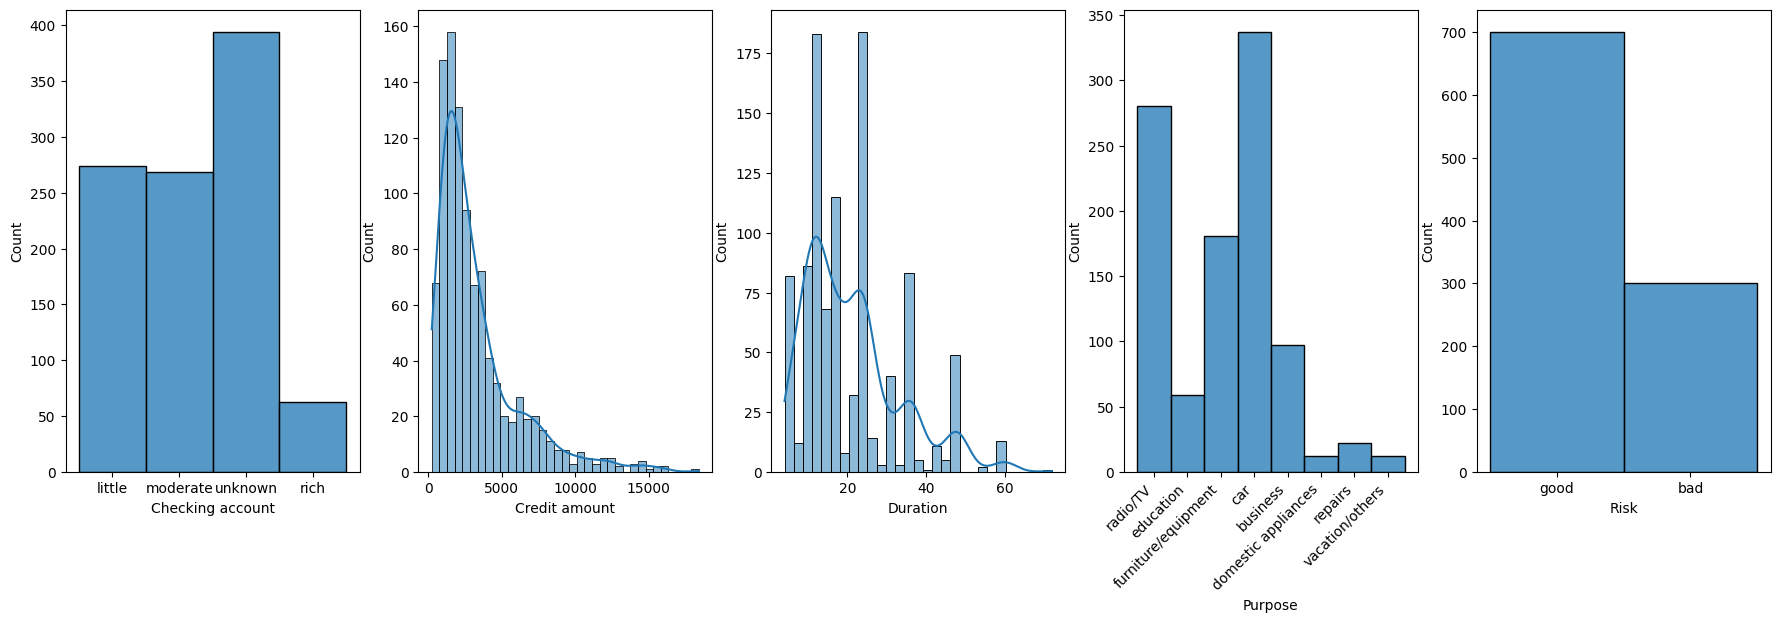

In [11]:
plot_dims = (22, 6)
fig, axs = plt.subplots(ncols=5, figsize=plot_dims)

# Plot 6 : Checking account
sns.histplot(data=df, x="Checking account", ax=axs[0])
# Plot 7 : Credit amount
sns.histplot(data=df, x="Credit amount", ax=axs[1], kde=True)
# Plot 8 : Duration
sns.histplot(data=df, x="Duration", ax=axs[2], kde=True)
# Plot 9 : Purpose
sns.histplot(data=df, x="Purpose", ax=axs[3])
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=45, ha="right")
# Plot 10 : Risk
sns.histplot(data=df, x="Risk", ax=axs[4]);

# Save figure into reports folder
output_path = os.path.join(output_dir_figures, "univariate_analysis_2.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

##### Treemaps

Treemaps for Housing, Saving accounts, Checking account and Purpose

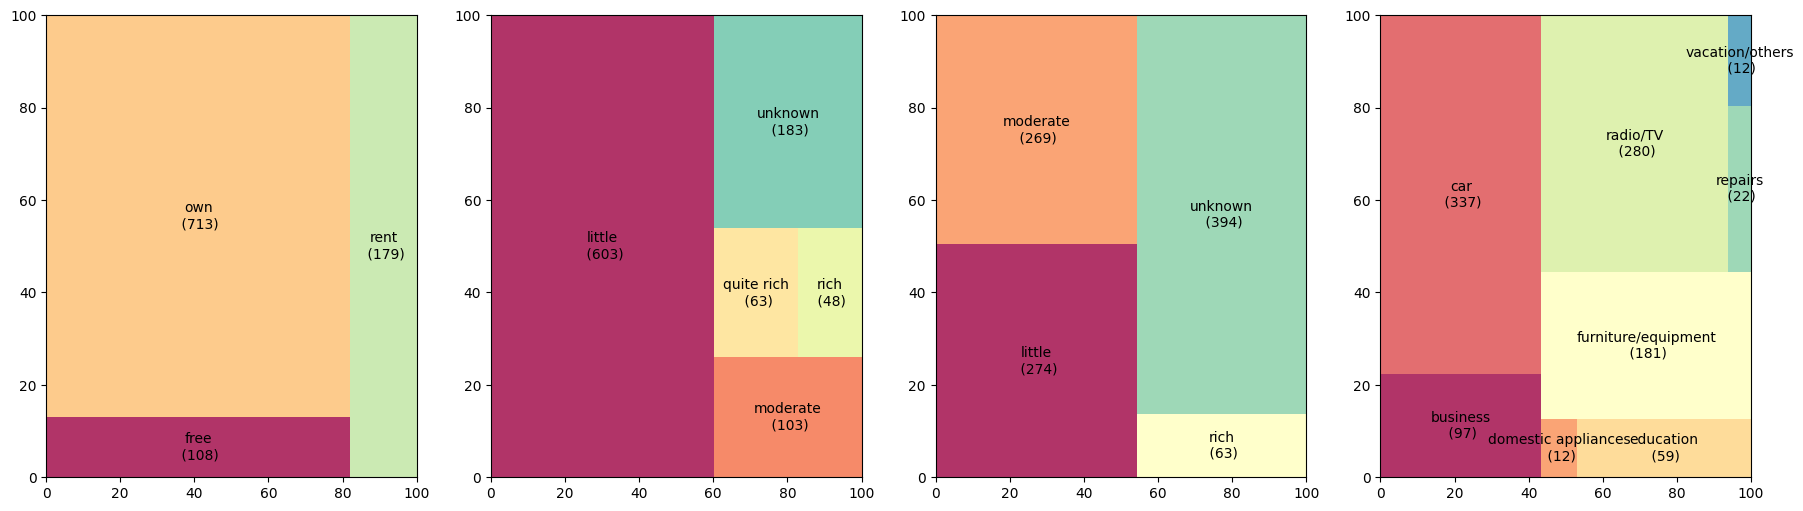

In [12]:
plot_dims = (22, 6)
fig, axs = plt.subplots(ncols=4, figsize=plot_dims)

nb = 0

# Count for each categories in order to plot it on the treemap
for category in ['Housing', 'Saving accounts', 'Checking account', 'Purpose'] :
    tr = df.groupby(category).size().reset_index(name='counts')
    labels = tr.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = tr['counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

    # Plot
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8, ax=axs[nb])
    
    nb+=1

# Save figure into reports folder
output_path = os.path.join(output_dir_figures, "treemaps_overview.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

Create categories for Purpose

Let's categorize the Purpose into 4 categories :
<ol>
<li> [EG] Essential Goods – for daily needs or essential usage: car, domestic appliances</li>
<li> [CLG] Comfort and Leisure Goods – for comfort or leisure but non-essential: radio/TV, furniture/equipment, vacation/others</li>
<li> [IPD] Investments or Personal Development – for skill development or business needs: business, education</li>
<li> [REP] Repairs – for existing items needing funds for restoration or maintenance: repairs</li>
</ol>

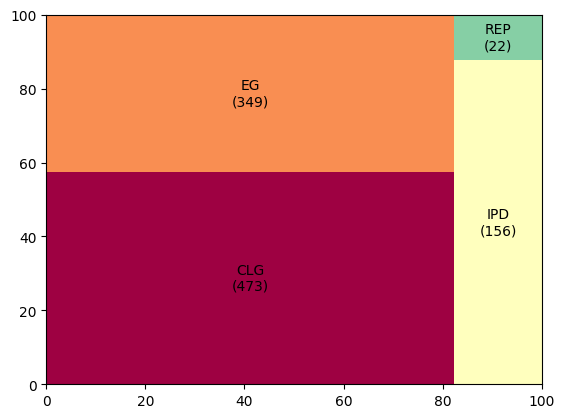

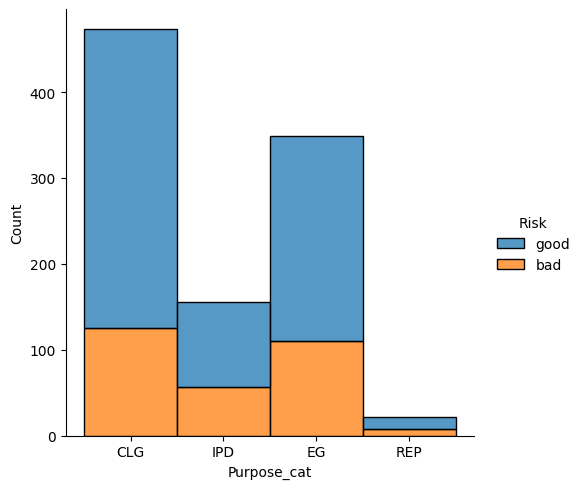

In [13]:
def categorize_purpose(purpose):
    if purpose in ['car', 'domestic appliances']:                           # Essential Goods
        return 'EG'
    elif purpose in ['radio/TV', 'furniture/equipment', 'vacation/others']: # Comfort and Leisure Goods
        return 'CLG'
    elif purpose in ['business', 'education']:                              # Investments or Personal Development
        return 'IPD'
    else:                                                                   # Repairs
        return 'REP'

# Apply categories to Purposes
cat = df['Purpose'].apply(categorize_purpose).value_counts().reset_index()
cat.columns = ['Purpose_cat', 'counts']

# Prepare labels and sizes
labels = cat.apply(lambda x: f"{x['Purpose_cat']}\n({x['counts']})", axis=1)
sizes = cat['counts'].values.tolist()
colors = [plt.cm.Spectral(i / float(len(labels))) for i in range(len(labels))]

# Stack display
df_cat = df.copy()
df_cat['Purpose_cat'] = df_cat['Purpose'].apply(categorize_purpose)

# Plot 1
squarify.plot(sizes=sizes, label=labels, color=colors)
# Save figure into reports folder
output_path = os.path.join(output_dir_figures, "treemap_purpose.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")
# Plot 2
sns.displot(df_cat, x="Purpose_cat", hue='Risk',multiple="stack")
# Save figure into reports folder
output_path = os.path.join(output_dir_figures, "stack_purpose.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")


#### Bivariate analysis

##### Boxplot Age/Gender

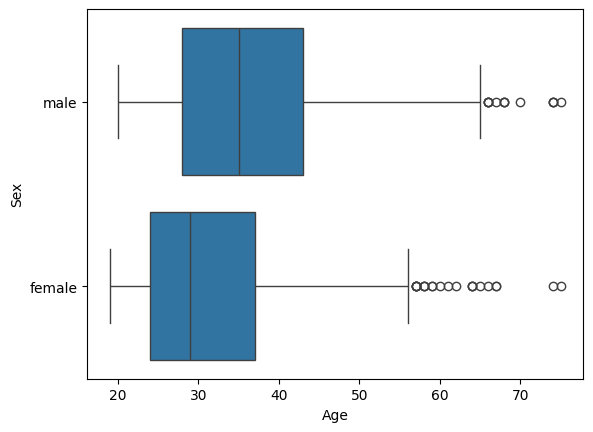

In [14]:
# Plot boxplot
sns.boxplot(data=df, x="Age", y="Sex");

# Save figure into reports folder
output_path = os.path.join(output_dir_figures, "boxplot_age.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

##### Job distribution Gender/Type

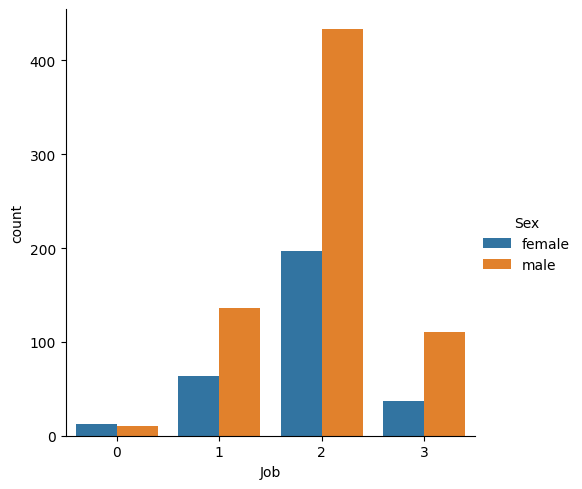

In [15]:
# Plot catplot
sns.catplot(data=df, x="Job", hue="Sex", kind="count");

# Save figure into reports folder
output_path = os.path.join(output_dir_figures, "job_distribution_sex.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

##### Boxplot Age_Category/Credit_Amount with Risk

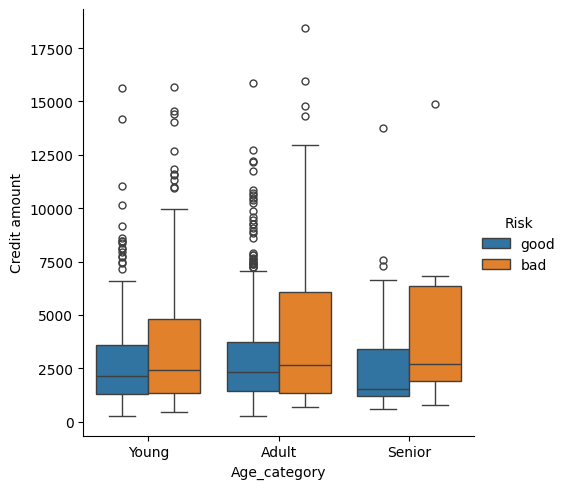

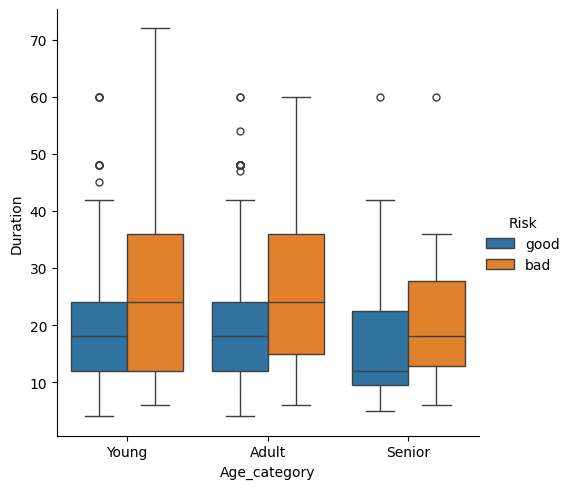

In [16]:
# Create age categories
def categorize_age(age):
    if 0 < age <= 30:
        return 'Young'
    elif 30 < age <= 60:
        return 'Adult'
    elif age > 60:                           
        return 'Senior'
    else:                                                         
        return 'unknown'
    
df_cat['Age_category'] = df_cat['Age'].apply(categorize_age)

# Plot 1
sns.catplot(data=df_cat, x="Age_category", y="Credit amount", hue="Risk", order=['Young','Adult','Senior'], kind="box")
# Save figure into reports folder
output_path = os.path.join(output_dir_figures, "credit_amount_by_age_category_w_risk.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Plot 2
sns.catplot(data=df_cat, x="Age_category", y="Duration", hue="Risk", order=['Young','Adult','Senior'], kind="box")
# Save figure into reports folder
output_path = os.path.join(output_dir_figures, "credit_duration_by_age_category_w_risk.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

Here, we can observe that credit duration and amount seem to be correlated with the risk: the higher the duration or the credit amount, the higher the risk. This observation appears to be quite logical.

##### Heatmap Duration/Credit Amount

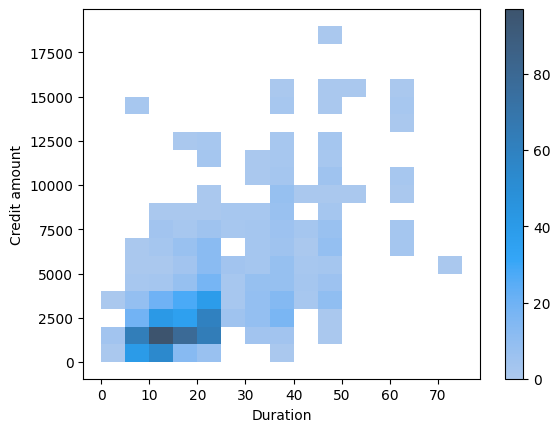

In [17]:
# Set bins
bins_x = np.arange(0, 80, 5) # Duration
bins_y = np.arange(0, 20000, 1000) # Credit Amount

# Plot heatmap
sns.histplot(data=df, x='Duration', y='Credit amount', bins=[bins_x, bins_y],cbar=True);

# Save figure into reports folder
output_path = os.path.join(output_dir_figures, "heatmap_credit_amout_duration.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

Majority of credits have a duration between 5 and 25 years, with a amount between 0 and 3750, as seen proviously during the Univariate analysis.

#### Overview

##### Pairplot

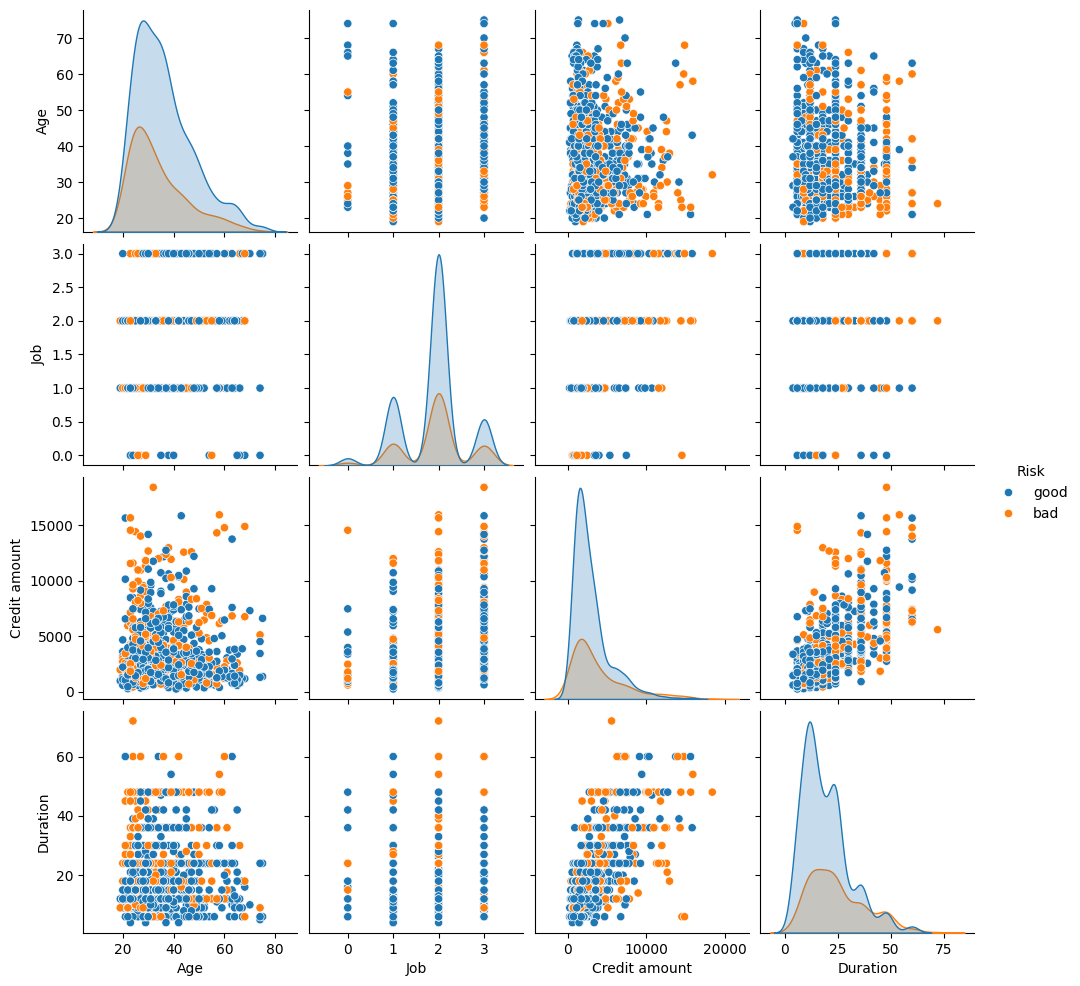

In [18]:
# Plot pairplot
sns.pairplot(df, hue='Risk', size=2.5);

# Save figure into reports folder
output_path = os.path.join(output_dir_figures, "pairplot.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

### Encoding categorical data

##### Encoding

In [19]:
# List of categorical columns
df_cat.select_dtypes(include='object').columns

Index(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose',
       'Risk', 'Purpose_cat', 'Age_category'],
      dtype='object')

In [20]:
df_cat.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Purpose_cat,Age_category
0,67,male,2,own,unknown,little,1169,6,radio/TV,good,CLG,Senior
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,CLG,Young
2,49,male,1,own,little,unknown,2096,12,education,good,IPD,Adult
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,CLG,Adult
4,53,male,2,free,little,little,4870,24,car,bad,EG,Adult


We are going to use the get_dummies function in order to switch from categorical to boolean values.

In [21]:
df_encoded = df_cat.copy()

# From categorical to Dummies Variable
df_encoded = df_encoded.merge(pd.get_dummies(df_encoded["Sex"], drop_first=True, prefix='Sex'), left_index=True, right_index=True)
df_encoded = df_encoded.merge(pd.get_dummies(df_encoded["Housing"], drop_first=True, prefix='Housing'), left_index=True, right_index=True)
df_encoded = df_encoded.merge(pd.get_dummies(df_encoded["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
df_encoded = df_encoded.merge(pd.get_dummies(df_encoded["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
df_encoded = df_encoded.merge(pd.get_dummies(df_encoded["Purpose"], drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
df_encoded = df_encoded.merge(pd.get_dummies(df_encoded["Risk"], prefix='Risk'), left_index=True, right_index=True)
df_encoded = df_encoded.merge(pd.get_dummies(df_encoded["Purpose_cat"], drop_first=True, prefix='Purpose_cat'), left_index=True, right_index=True)
df_encoded = df_encoded.merge(pd.get_dummies(df_encoded["Age_category"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)

# Filtering previous columns
droplist=["Sex", "Housing", "Saving accounts", "Checking account", "Purpose", "Risk", "Risk_good", "Purpose_cat", "Age_category"]
df_encoded.drop(droplist, axis= 1, inplace = True)

df_encoded.head()

,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Savings_moderate,Savings_quite rich,Savings_rich,...,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_bad,Purpose_cat_EG,Purpose_cat_IPD,Purpose_cat_REP,Age_cat_Senior,Age_cat_Young
0,67,2,1169,6,True,True,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
1,22,2,5951,48,False,True,False,False,False,False,...,False,True,False,False,True,False,False,False,False,True
2,49,1,2096,12,True,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,45,2,7882,42,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,53,2,4870,24,True,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False


Export to CSV in the processed data folder

In [35]:
processed_data_path = Path('../data/processed/german_credit_data_encoded.csv')
df_encoded.to_csv(processed_data_path)

##### Correlation heatmap

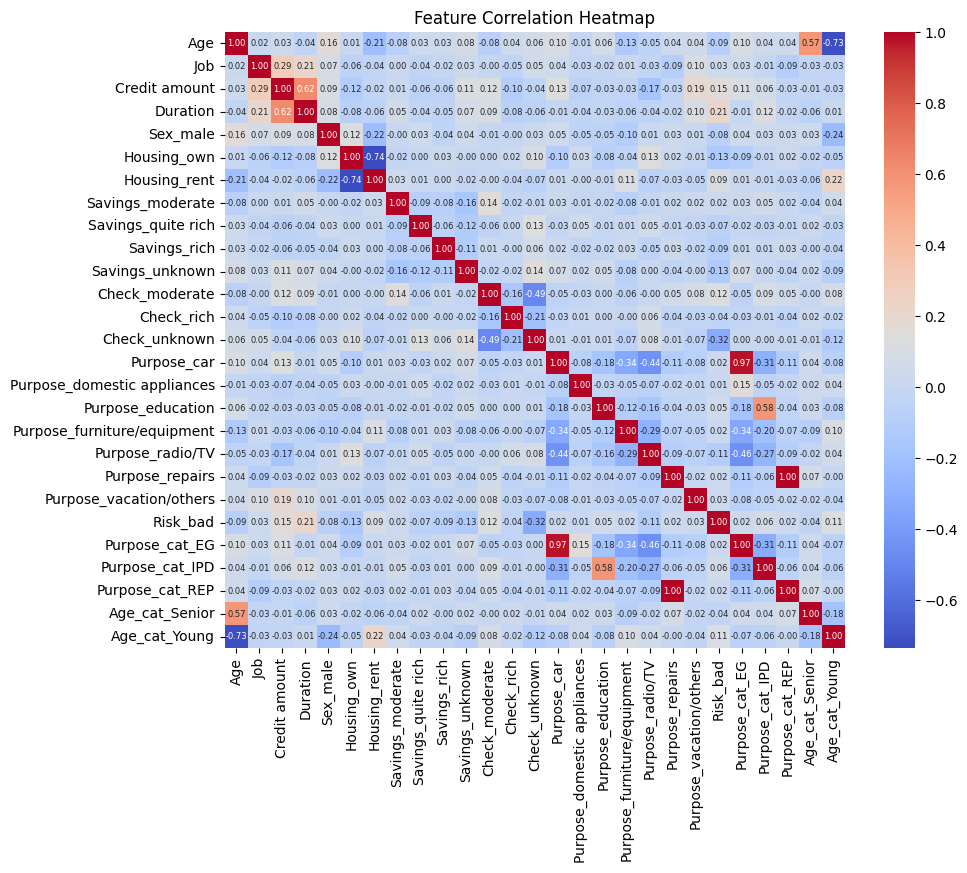

<Figure size 640x480 with 0 Axes>

In [22]:
# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=True,fmt=".2f",annot_kws={'size':6},cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Save figure into reports folder
output_path = os.path.join(output_dir_figures, "correlation_heatmap.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

We can observe some correlation, like for age and age_categories, purpose with purpose_categories, housing, ... which are not relevant.
There is also a correlation which seems logical, between the credit amount and duration, which was seen on the previous Duration/Credit Amount Heatmap.

### Splitting the dataset

In [23]:
# Creating the X and y variables
X = df_encoded.drop('Risk_bad', axis = 1)
y = df_encoded["Risk_bad"]

seed = 1234

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=seed)

### Standardization

In [24]:
# Standardisation de X_train et application de cette standardisation sur X_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Calcul de la moyenne et écart-type sur X_train
X_test = scaler.transform(X_test)        # Application de la transformation sur X_test

### Model building

For predicting a binary target like Risk_bad, we are going to focus on the following models :
1.	Logistic Regression (LR): A simple baseline, great for interpretability 
2.	K-Nearest Neighbors (KNN): Simple and interpretable, works best with normalized features
3.	Naive Bayes (NB): Fast and effective for independent categorical features
4.	Random Forest (RF): Robust and interpretable for tabular data
5.	Decision Tree (KNN): Quick and interpretable, but prone to overfitting without regularization
6.	Gradient Boosting Model (XGB) : High-performing model, especially for structured data
7.	Support Vector Machine (SVM): Effective for smaller datasets

#### Overview

Model :  LR , Recall mean :  0.3757948968355147 , Recall std :  0.06060504828293339
Model :  KNN , Recall mean :  0.3214047283549572 , Recall std :  0.0872490098359166
Model :  NB , Recall mean :  0.5082781861328771 , Recall std :  0.11366446370517531
Model :  RF , Recall mean :  0.37798806509618865 , Recall std :  0.07981342998710265
Model :  CART , Recall mean :  0.4990462041348769 , Recall std :  0.09927198335524318
Model :  XGB , Recall mean :  0.4537600463355612 , Recall std :  0.09032540902166412
Model :  SVM , Recall mean :  0.2769025939735322 , Recall std :  0.0650237019538255


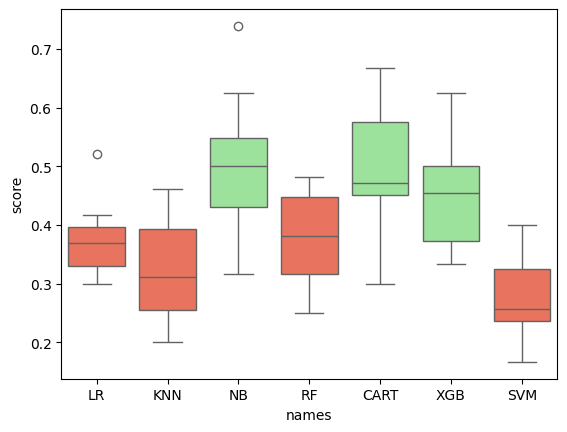

In [25]:
results = pd.DataFrame(columns = ['names', 'score'])
scoring = 'recall'

models = [
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('NB', GaussianNB()),
    ('RF', RandomForestClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('XGB', XGBClassifier()),
    ('SVM', SVC(gamma='auto'))
]

for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    new_row = pd.DataFrame({'names': name, 'score': cv_results})
    results = pd.concat([results, new_row], ignore_index=True)
    print("Model : ",name,", Recall mean : ",cv_results.mean(),", Recall std : ",cv_results.std())

# Display recall boxplot for each model
mean_scores = results.groupby("names")["score"].mean()
palette = {name: "lightgreen" if mean_score > 0.45 else "tomato" for name, mean_score in mean_scores.items()}
sns.boxplot(data=results, x="names", y="score", palette=palette);

# Save figure into reports folder
output_path = os.path.join(output_dir_figures, "models_scores_overview.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

Let's select NB, CART and XGB to continue, by processing some hyperparameter tuning and try to improve the results

#### Naive Bayes - Hyperparameter Tunning

In [26]:
GNB = GaussianNB()
print(GNB.get_params())

{'priors': None, 'var_smoothing': 1e-09}


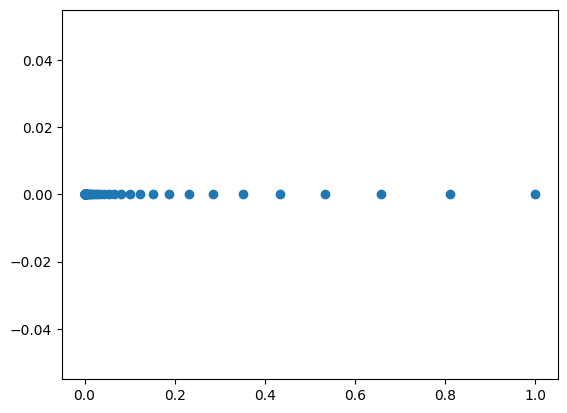

In [27]:
test_log_x = np.logspace(0,-9, num=100)
test_log_y = np.zeros(100)
plt.plot(test_log_x, test_log_y, 'o')

In [28]:
# Define the hyperparameter grid for the Gaussian Naive Bayes model
params_NB = {'var_smoothing': np.logspace(0,-1, num=100)}
# 'var_smoothing' adds a small value to the variance to avoid dividing by zero, 
# tested here across 100 logarithmically spaced values between 10^0 and 10^-1

# Set up the grid search for hyperparameter tuning with cross-validation
grid_GNB = GridSearchCV(estimator=GNB, 
                 param_grid=params_NB, 
                 cv=5, 
                 verbose=1, 
                 scoring='accuracy')

# Fit the model on the training data using the grid search
model_NB = grid_GNB.fit(X_train, y_train)

# Print the best hyperparameters found during the grid search
print("Best params : ", model_NB.best_params_,"\n")

# Use the best model from the grid search to make predictions on the test data
y_pred_NB = model_NB.predict(X_test)

# Model evaluation
accuracy_score_NB = accuracy_score(y_test,y_pred_NB)
f1_score_NB = f1_score(y_test, y_pred_NB)

print("Test predict accuracy score: ", accuracy_score_NB,"\n")
print("F1-score:", f1_score_NB)
print("\n Confussion Matrix: \n", confusion_matrix(y_test, y_pred_NB),"\n")
print("Classification report according to Test prediction: \n", classification_report(y_test, y_pred_NB))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params :  {'var_smoothing': np.float64(0.8697490026177833)} 

Test predict accuracy score:  0.664 

F1-score: 0.3225806451612903

 Confussion Matrix: 
 [[146  26]
 [ 58  20]] 

Classification report according to Test prediction: 
               precision    recall  f1-score   support

       False       0.72      0.85      0.78       172
        True       0.43      0.26      0.32        78

    accuracy                           0.66       250
   macro avg       0.58      0.55      0.55       250
weighted avg       0.63      0.66      0.63       250



#### XGBoost - Hyperparameter Tunning

In [29]:
# Initialize the XGBoost classifier with a fixed random seed for reproducibility
model_XGB = XGBClassifier(random_state=seed)

# Define the parameter grid for hyperparameter tuning
grid_params_XGB = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
     "n_estimators"     : [10, 20, 30]
     }

# Set up the grid search for hyperparameter tuning with cross-validation
grid_XGB = GridSearchCV(model_XGB, grid_params_XGB, cv=3, n_jobs=-1)

# Fit the model on the training data using the grid search
model_XGB = grid_XGB.fit(X_train, y_train)

# Retrieve the best estimator and the best hyperparameters found during the grid search
model_XGB.best_estimator_
model_XGB.best_params_

{'colsample_bytree': 0.7,
 'eta': 0.15,
 'gamma': 0.3,
 'max_depth': 12,
 'min_child_weight': 1,
 'n_estimators': 20}

In [30]:
# Use the best model from the grid search to make predictions on the test data
y_pred_XGB = grid_XGB.predict(X_test)

# Model evaluation
accuracy_score_XGB = accuracy_score(y_test,y_pred_XGB)
f1_score_XGB = f1_score(y_test, y_pred_XGB)

print("Test predict accuracy score: ", accuracy_score_XGB,"\n")
print("F1-score:", f1_score_XGB)
print("\n Confussion Matrix: \n", confusion_matrix(y_test, y_pred_XGB),"\n")
print("Classification report according to Test prediction: \n", classification_report(y_test, y_pred_XGB))

Test predict accuracy score:  0.732 

F1-score: 0.40707964601769914

 Confussion Matrix: 
 [[160  12]
 [ 55  23]] 

Classification report according to Test prediction: 
               precision    recall  f1-score   support

       False       0.74      0.93      0.83       172
        True       0.66      0.29      0.41        78

    accuracy                           0.73       250
   macro avg       0.70      0.61      0.62       250
weighted avg       0.72      0.73      0.70       250



#### KNN

In [31]:
# Define the parameter grid for hyperparameter tuning
grid_params_KNN = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

# Set up the grid search for hyperparameter tuning with cross-validation
grid_KNN = GridSearchCV(KNeighborsClassifier(), grid_params_KNN, verbose = 1, cv=3, n_jobs = -1)

# Fit the model on the training data using the grid search
model_KNN = grid_KNN.fit(X_train, y_train)

# Retrieve the best estimator and the best hyperparameters found during the grid search
model_KNN.best_score_
model_KNN.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}

In [32]:
# Fit the model on the training data using the grid search
model_KNN.fit(X_train, y_train)

# Use the best model from the grid search to make predictions on the test data
y_pred_KNN = model_KNN.predict(X_test)

# Model evaluation
accuracy_score_KNN = accuracy_score(y_test,y_pred_KNN)
f1_score_KNN = f1_score(y_test, y_pred_KNN)

print("Test predict accuracy score: ", accuracy_score_KNN,"\n")
print("F1-score:", f1_score_KNN)
print("\n Confussion Matrix: \n", confusion_matrix(y_test, y_pred_KNN),"\n")
print("Classification report according to Test prediction: \n", classification_report(y_test, y_pred_KNN))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Test predict accuracy score:  0.716 

F1-score: 0.3486238532110092

 Confussion Matrix: 
 [[160  12]
 [ 59  19]] 

Classification report according to Test prediction: 
               precision    recall  f1-score   support

       False       0.73      0.93      0.82       172
        True       0.61      0.24      0.35        78

    accuracy                           0.72       250
   macro avg       0.67      0.59      0.58       250
weighted avg       0.69      0.72      0.67       250



### Model synthesis - ROC Curve analysis

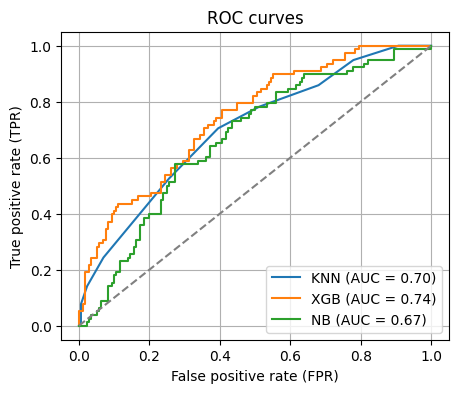

<Figure size 640x480 with 0 Axes>

In [33]:
# ROC curve and AUC score calculation for each model
models = {'KNN': (model_KNN, y_pred_KNN),
          'XGB': (model_XGB, y_pred_XGB),
          'NB': (model_NB, y_pred_NB)}

plt.figure(figsize=(5, 4))

for name, (model, y_pred) in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        raise ValueError(f"Model {name} do not handle prob calculation")

    # ROC curve calculation
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)

    # Trace
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

# Graphical part
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal
plt.title("ROC curves")
plt.xlabel("False positive rate (FPR)")
plt.ylabel("True positive rate (TPR)")
plt.legend()
plt.grid()
plt.show()

# Save figure into reports folder
output_path = os.path.join(output_dir_figures, "roc_curves_tuned_models.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

The XGB ROC curve is above the KNN and NB ones, which are pretty similar. Note that the closer the curve comes to the diagonal of the ROC space, the less accurate the test. It means that the KNN model performs better than the other ones.

### Conclusion

In [34]:
NB_dict = {'Accuracy_Score':accuracy_score_NB, 'F1-score':f1_score_NB}
KNN_dict = {'Accuracy_Score':accuracy_score_KNN, 'F1-score':f1_score_KNN}
XGB_dict = {'Accuracy_Score':accuracy_score_XGB,'F1-score':f1_score_XGB}

resume = pd.DataFrame({'Naive Bayes':pd.Series(NB_dict),
                       'KNN':pd.Series(KNN_dict),
                       'XGB':pd.Series(XGB_dict)
                      })

resume

,Naive Bayes,KNN,XGB
Accuracy_Score,0.664000,0.716000,0.73200
F1-score,0.322581,0.348624,0.40708


Based on the evaluation metrics, the XGBoost (XGB) model is the best-performing model among the three considered.
- Accuracy Score: XGB achieves the highest accuracy (73.2%) compared to KNN (69.2%) and Naive Bayes (66.4%). This indicates that XGB predicts correctly in a larger proportion of cases.
- F1-Score: XGB also demonstrates superior performance with an F1-score of 0.407, outperforming KNN (0.330) and Naive Bayes (0.323). The F1-score combines precision and recall, making it particularly relevant for imbalanced datasets.
- ROC Curve: The ROC curve for XGB is consistently above those for KNN and Naive Bayes, which are close to each other. This reflects a better trade-off between true positive and false positive rates for the XGB model.

In conclusion, XGB is the most effective model based on all three metrics, demonstrating its ability to generalize well and make balanced predictions. It should therefore be selected for deployment.